# DP0.2 Object Catalog tutorial -- Part III: Using Rubin analysis tools

Owners: **PatriciaLarsen [@plarsen](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@patricialarsen)**  
Last Verifed to Run: **2024-06-04** (by @plarsen)

This notebook will show you how to run the Rubin Observatory's analysis tools validation metrics on NERSC. We first access the DP0.2 object catalog through the Generic Catalog Reader (GCR, https://github.com/yymao/generic-catalog-reader), and then run through the tutorial task from the analysis tools framework. 


__Learning objectives__:

After going through this notebook, you should be able to:
  1. Load the DP0.2 object catalog with the GCR
  2. Run analysis tools validation metrics 
  3. Refer back to the analysis_tools documentation and create new metrics and plots

  
__Important Notes__:
- Analysis tools is primarily designed for the project's purposes, as such it may be updated frequently and has broad functionality, which overlaps with but is not fully inclusive of all the testing that DESC requires. They're always looking for more contributors so if you're interested in this development go ahead and get in touch. Do bear in mind that DESC-specific tests, especially those which require large volumes of data or external data may not be in scope for analysis tools development. However if you develop a test using this framework, we can easily include this in the SRV testing suite. If you've got a test you'd like included please ping plarsen on slack! 


__Logistics__: This notebook is intended to be run through the JupyterHub NERSC interface available here: https://jupyter.nersc.gov. To setup your NERSC environment, please follow the instructions available here: https://confluence.slac.stanford.edu/display/LSSTDESC/Using+Jupyter+at+NERSC

__Kernel__: Please use desc-stack-weekly-latest for this tutorial

## What is Analysis Tools?

This is the Rubin Observatory's package for the creation of plots and metrics, designed to make sure validation metrics are consistent and repeatable. You may know it by the previous iteration called Faro or from its stunning plots.   


The best place to find information on analysis tools is the Getting Started documentation here:
https://pipelines.lsst.io/v/daily/modules/lsst.analysis.tools/getting-started.html#analysis-tools-getting-started, and for support the slack channel #rubinobs-analysis-tools-support

Note that it has now been merged into the most recent version of the lsst pipelines so no longer needs to be installed separately. Just use the desc-stack-weekly-latest kernel on your notebook.

__FAQ__:

Q. How about metrics from different observing strategies? 

A. That's the metric-analysis-framework, or MAF: https://www.lsst.org/scientists/simulations/maf


Let's start with the standard imports, including GCRCatalogs which will be used to load the DP0.2 data. The standard examples for running analysis_tools use the Butler, but we do not have the DP0.2 data in a butler repository on NERSC as far as I'm aware (please do correct me if I'm wrong!). Luckily we can run this on any data :) 

In [127]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys
import time

In [128]:
sys.path.insert(0,'/global/cfs/projectdirs/lsst/groups/SRV/gcr-catalogs-test')
import GCRCatalogs

# Load the object catalog - this uses lsst notation and is the full DP0.2 coadd object catalogs
catalog = GCRCatalogs.load_catalog('lsst_object_full')

## Example

Let's follow the tutorial task from the getting_started docs and show how to do this on the DP0.2 data. We do need to make one major change. DP0.2 doesn't have an ebv column so we can't use extinction-corrected magnitudes and need to swap from that to the normal magnitudes. I've commented out and replaced the lines below.

In [120]:
import lsst.analysis.tools
from lsst.analysis.tools.interfaces import AnalysisTool
from lsst.analysis.tools.actions.vector import CoaddPlotFlagSelector, SnSelector, StarSelector, LoadVector, MagDiff
from lsst.analysis.tools.actions.scalar import MedianAction, MeanAction, SigmaMadAction
from lsst.analysis.tools.actions.plot import SkyPlot
from lsst.analysis.tools.atools import ShapeSizeFractionalDiff
from lsst.analysis.tools.interfaces._task import _StandinPlotInfo


In [113]:
class newPlotMetric(AnalysisTool):
    def setDefaults(self):
        super().setDefaults()
        self.prep.selectors.flagSelector = CoaddPlotFlagSelector()
        self.prep.selectors.flagSelector.bands = ['r']

        self.prep.selectors.snSelector = SnSelector()
        self.prep.selectors.snSelector.fluxType = "{band}_psfFlux"
        self.prep.selectors.snSelector.threshold = 300

        self.prep.selectors.starSelector = StarSelector()
        self.prep.selectors.starSelector.vectorKey = "{band}_extendedness"

        self.process.buildActions.xStars = LoadVector()
        self.process.buildActions.xStars.vectorKey = "coord_ra"
        self.process.buildActions.yStars = LoadVector()
        self.process.buildActions.yStars.vectorKey = "coord_dec"

        self.process.buildActions.starStatMask = SnSelector()
        self.process.buildActions.starStatMask.fluxType = "{band}_psfFlux"

        self.process.buildActions.zStars = MagDiff()
        self.process.buildActions.zStars.col1 = "{band}_ap12Flux"
        self.process.buildActions.zStars.col2 = "{band}_psfFlux"


        #self.process.buildActions.zStars = ExtinctionCorrectedMagDiff()
        #self.process.buildActions.zStars.magDiff.col1 = "{band}_ap12Flux"
        #self.process.buildActions.zStars.magDiff.col2 = "{band}_psfFlux"

        self.process.calculateActions.median = MedianAction()
        self.process.calculateActions.median.vectorKey = "zStars"

        self.process.calculateActions.mean = MeanAction()
        self.process.calculateActions.mean.vectorKey = "zStars"

        self.process.calculateActions.sigmaMad = SigmaMadAction()
        self.process.calculateActions.sigmaMad.vectorKey = "xStars"

        self.produce.plot = SkyPlot()
        self.produce.plot.plotTypes = ["stars"]
        self.produce.plot.plotName = "ap12-psf_{band}"
        self.produce.plot.xAxisLabel = "R.A. (degrees)"
        self.produce.plot.yAxisLabel = "Dec. (degrees)"
        self.produce.plot.zAxisLabel = "Ap 12 - PSF [mag]"
        self.produce.plot.plotOutlines = False

        self.produce.metric.units = {
            "median": "mmag",
            "sigmaMad": "mmag",
            "mean": "mmag"
        }

        self.produce.metric.newNames = {
            "median": "{band}_ap12-psf_median",
            "mean": "{band}_ap12-psf_mean",
            "sigmaMad": "{band}_ap12-psf_sigmaMad",
        }


To interface with our reader we need to know which quantities we'll need! Luckily the tools can provide this for us and we can convert them into a list fairly easily. Here's a convenience function which inputs the tool and the bands, and outputs the quantities. 

In [114]:
def get_quantities(tool,bands):
    tool.populatePrepFromProcess()
    key_list = list(tool.prep.getInputSchema())
    quantities = []
    for key in key_list:
        if '{band}' in key[0]:
            for band in bands:
                quantities.append(key[0].format(band=band))
        else:
            quantities.append(key[0])
    quantities = np.unique(quantities)
    return quantities


In [121]:
analysis = newPlotMetric()
key_list = get_quantities(analysis,['r'])

## Running the Metric

Now we can read in the data in the normal way, analysis_tools needs a key-based data product but luckily this is already in that format!
Then we simply need to create the PlotInfoDict, assign a band and pass the data to the analysis task!

In [112]:

filters = ['detect_isPrimary', "r_ra > 0", "r_decl < -40"]
data = catalog.get_quantities(key_list, filters =filters)  


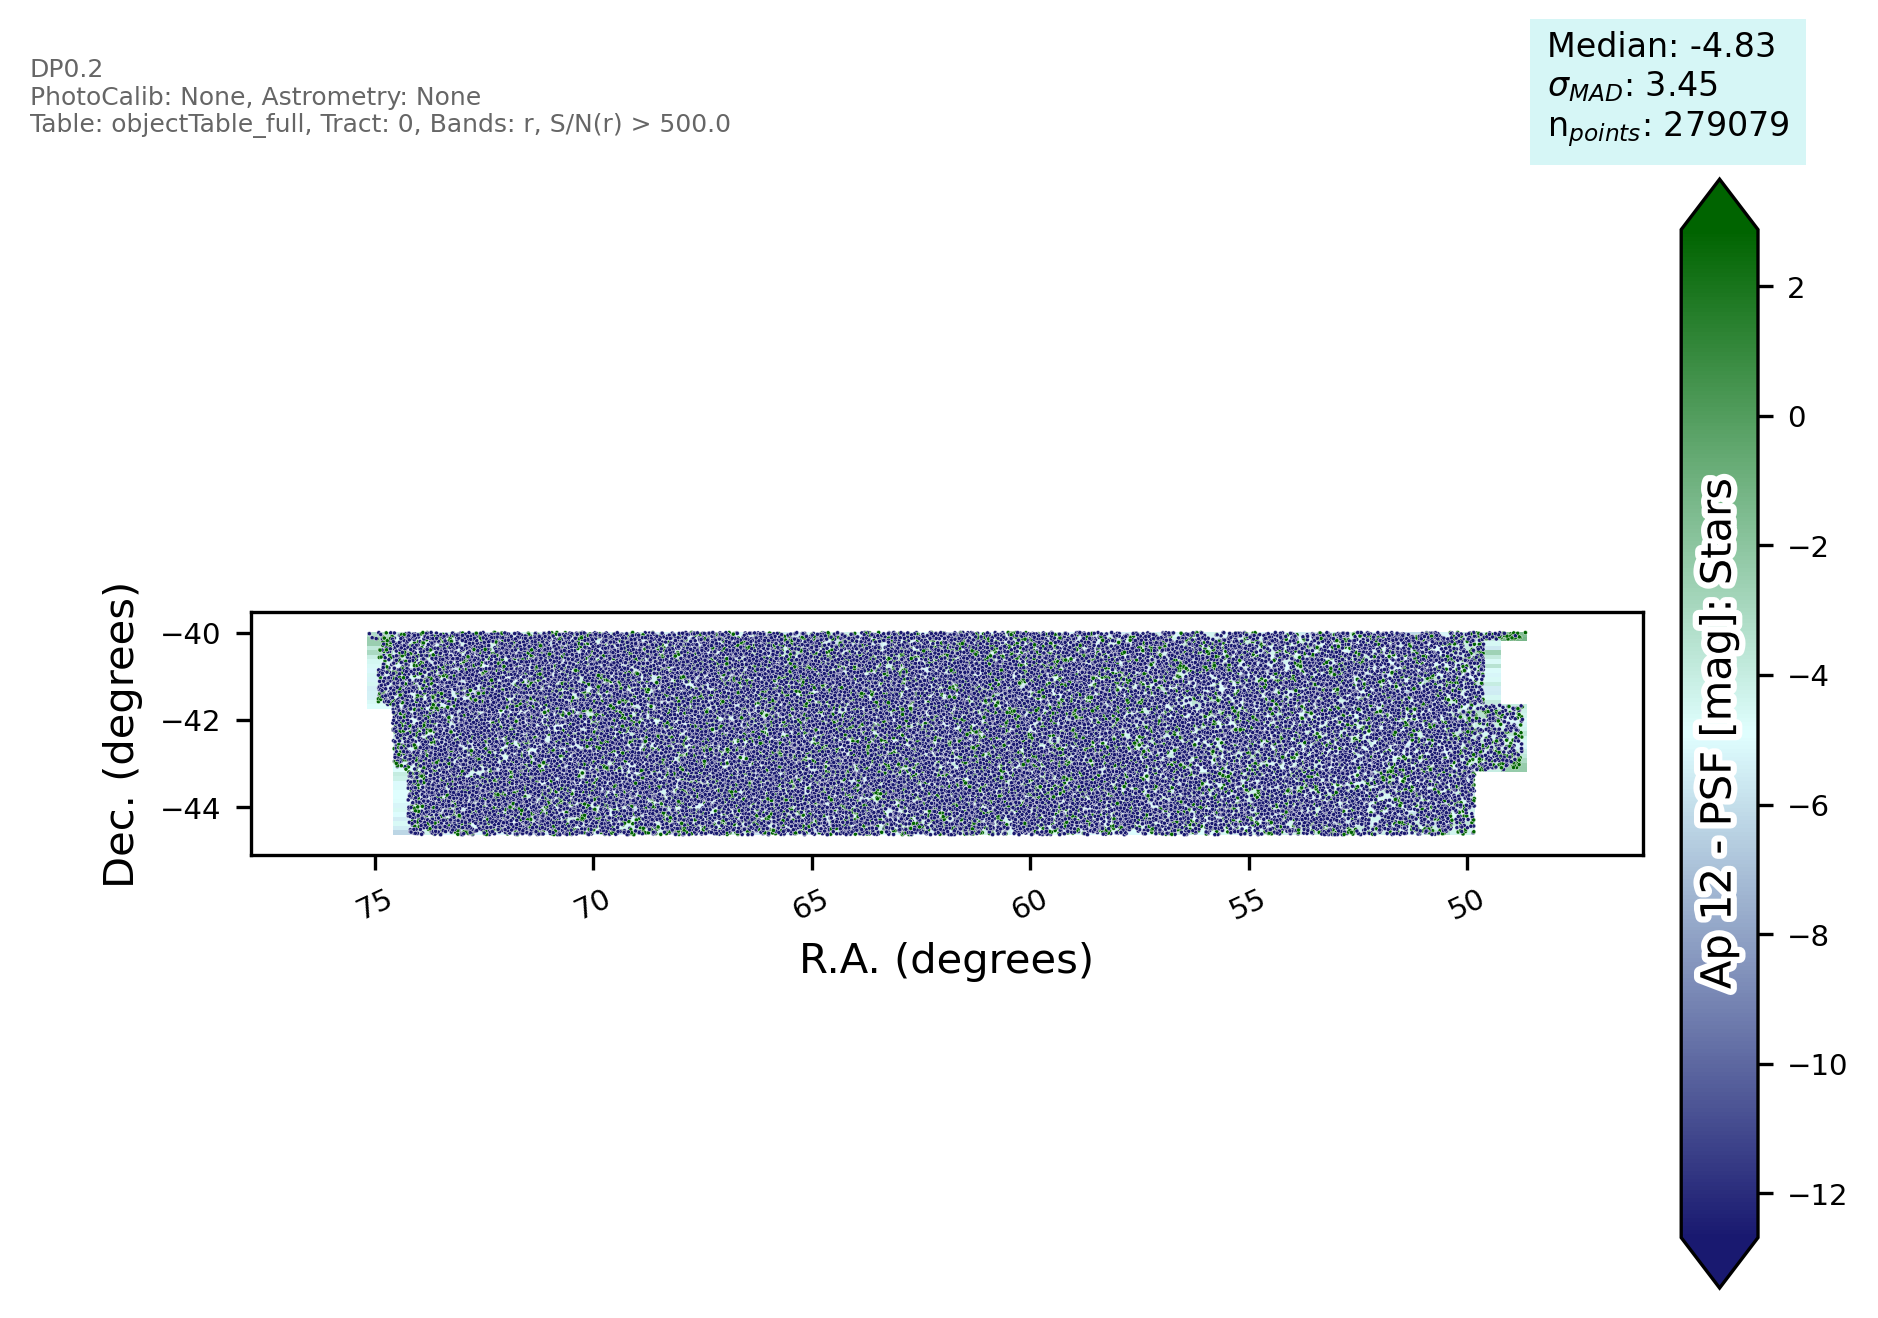

In [119]:
plotInfoDict = {"bands": "r", "tract": 0, "tableName": "objectTable_full", "run": "DP0.2"}
analysis.finalize()
results = analysis(data, band="r", plotInfo=plotInfoDict)


There are a few more result metrics here in a dictionary format, along with the plot. If you'd like to try a wider variety of plots go through the getting started documentation (plot types are here: https://pipelines.lsst.io/v/daily/modules/lsst.analysis.tools/plot-types.html, action types are here: https://pipelines.lsst.io/v/daily/modules/lsst.analysis.tools/action-types.html). If you create an example that you think would be useful for others please ping the SRV group on slack and we'll get it added here!

In [126]:
print(results)

{'SkyPlot': <Figure size 1920x1440 with 2 Axes>, 'r_ap12-psf_median': Measurement('r_ap12-psf_median', <Quantity -4.90539626 mmag>, notes={'r_ap12-psf_median.metric_tags': []}), 'r_ap12-psf_sigmaMad': Measurement('r_ap12-psf_sigmaMad', <Quantity 9.15585847 mmag>, notes={'r_ap12-psf_sigmaMad.metric_tags': []}), 'r_ap12-psf_mean': Measurement('r_ap12-psf_mean', <Quantity -9.15795041 mmag>, notes={'r_ap12-psf_mean.metric_tags': []})}
